In [1]:
import torch, torchvision
import numpy as np
import pandas as pd
import os
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [2]:
# Helper for visualization
def torch_imshow(img):
    img = img.permute(1,2,0)
    plt.imshow(img.cpu().numpy())
    plt.show()

In [3]:
# Mounting Google Drive 

from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import os

# The path to Covid dataset directory

dataset_path = '/content/gdrive/MyDrive/MI502_Project'

training_set_path = os.path.join(dataset_path, 'training_set')
validation_set_path = os.path.join(dataset_path, 'validation_set')
test_set_path = os.path.join(dataset_path, 'test_set')

print(training_set_path)
print(validation_set_path)
print(test_set_path)

/content/gdrive/MyDrive/MI502_Project/training_set
/content/gdrive/MyDrive/MI502_Project/validation_set
/content/gdrive/MyDrive/MI502_Project/test_set


In [5]:
# Training dataset transforms
# Random horizontal flip with probability 0.5 as data augmentation
# Resizing images to 100 x 100
# Converting images to torch tensor

training_transforms = torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.Resize(size=(100, 100)),
        torchvision.transforms.ToTensor()
])

training_dataset = torchvision.datasets.ImageFolder(root=training_set_path, 
                                                    transform=training_transforms)

In [6]:
# Validation dataset transforms
# Resizing images to 100 x 100
# Converting images to torch tensor

validation_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(100, 100)),
    torchvision.transforms.ToTensor()
])

validation_dataset = torchvision.datasets.ImageFolder(root=validation_set_path, 
                                                      transform=validation_transforms)

In [7]:
# Test dataset transforms
# Resizing images to 100 x 100
# Converting images to torch tensor

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(100, 100)),
    torchvision.transforms.ToTensor()
])

test_dataset = torchvision.datasets.ImageFolder(root=test_set_path, 
                                                    transform=test_transforms)

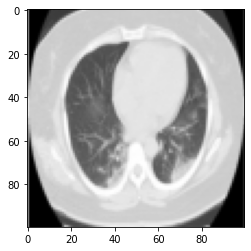

Label for covid: 0


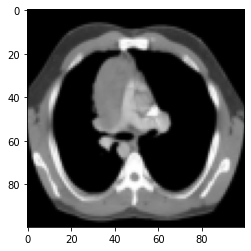

Label for noncovid: 1


In [8]:
# Visualizing images from each class 

covid_img, covid_label = training_dataset[1]
torch_imshow(covid_img)
print(f'Label for covid: {covid_label}')

noncovid_img, noncovid_label = training_dataset[-1]
torch_imshow(noncovid_img)
print(f'Label for noncovid: {noncovid_label}')

In [9]:
# Preparing Data Loaders with Batch Size of 32 for all datasets and Shuffling only Training Dataset

training_dataloader   = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_dataloader       = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
# Stride of 1 for convolutional layers
# Stride of 3 for max pooling layer
# ReLU activation for hidden layers
# Batch normalization after all convolutional layers
# Dropout with 0.1 probability for the hidden fully connected layer
# Softmax activation in the final layer

class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__() 
        
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1)        
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=3,stride=3)
        self.batchnorm1 = torch.nn.BatchNorm2d(num_features=16)
        self.relu = torch.nn.ReLU
        
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1)       
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=3,stride=3)      
        self.batchnorm2 = torch.nn.BatchNorm2d(num_features=32)  
        self.relu = torch.nn.ReLU
        
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1)        
        self.maxpool3 = torch.nn.MaxPool2d(kernel_size=3,stride=3)
        self.batchnorm3 = torch.nn.BatchNorm2d(num_features=32)
        self.relu = torch.nn.ReLU
        
        self.fc1 = torch.nn.Linear(32*1*1, 16)       
        self.dropout1 = torch.nn.Dropout2d(0.1)
        self.relu = torch.nn.ReLU

        self.fc2 = torch.nn.Linear(16, 2)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.batchnorm1(x)
        
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.batchnorm2(x)      

        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.batchnorm3(x)

        x = x.view(-1,32*1*1)
        x = self.fc1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
                     
        x = torch.nn.functional.softmax(x,dim = 1)
      

        return x
        

test_convnet = ConvNet().to('cuda')
test_input = torch.randn(16, 3, 100, 100, device='cuda')
test_output = test_convnet(test_input)
print(test_output.shape)

torch.Size([16, 2])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [11]:
# Defining loss function
loss_fn = torch.nn.CrossEntropyLoss()

In [12]:
# Defining optimizer
optimizer = torch.optim.Adam(ConvNet().to('cuda').parameters(),lr = 0.01)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    maximize: False
    weight_decay: 0
)


In [13]:
# Defining a function that takes a model and a dataloader and outputs model accuracy on the dataloader

def check_accuracy(neuralnet, dataloader):
    

    true_predictions = 0
    false_predictions = 0
    
    for images,labels in dataloader:

      # Move batch to GPU
      images, labels = images.cuda(), labels.cuda()

      # Run the network with images batch and obtain the class scores
      class_scores = neuralnet(images)

      # Extracting predictions from class_scores using torch.argmax() method
      class_predictions = torch.argmax(class_scores,dim=-1)      
    
      # True and false predictions in the batch using test_labels and class_predictions
      true_predictions_batch  = torch.sum(class_predictions == labels)
      false_predictions_batch = torch.sum(class_predictions != labels)
    
      true_predictions  += true_predictions_batch.item()
      false_predictions += false_predictions_batch.item()

      accuracy = true_predictions / (true_predictions + false_predictions)
       

    return accuracy

In [14]:
# Caclulating the test accuracy before training

test_accuracy = check_accuracy(test_convnet, test_dataloader)
print(f'Test accuracy before training: {test_accuracy * 100 :.2f}%')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Test accuracy before training: 52.67%


In [15]:
# Training the model for 1 epoch

def train_one_epoch(neuralnet, dataloader, optimizer, loss_fn):
    
    for imgs_batch, labels_batch in dataloader:
        imgs_batch, labels_batch = imgs_batch.to("cuda"), labels_batch.to("cuda")     
        
        # Run the network with images batch and obtain the class scores
        class_scores = neuralnet(imgs_batch)
   
        # Calculating loss using the loss function defined above
        loss = loss_fn(class_scores, labels_batch)

        # Taking an optimization step 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [16]:
train_convnet = ConvNet().to('cuda')
validation_convnet = ConvNet().to('cuda')

In [17]:
# Use the training function you defined above to train your network on training set.

training_accuracy_list = []
validation_accuracy_list = []

NUM_EPOCHS = 15 

for epoch_no in range(NUM_EPOCHS):
    print(f'Epoch {epoch_no + 1}...')
    
    train_one_epoch(test_convnet, training_dataloader, optimizer, loss_fn)
    
    training_accuracy = check_accuracy(test_convnet, training_dataloader)
    print(f'Training   accuracy: {training_accuracy * 100 :.2f}%')
    validation_accuracy = check_accuracy(test_convnet, validation_dataloader)
    print(f'Validation accuracy: {validation_accuracy * 100 :.2f}%')
    
    training_accuracy_list.append(training_accuracy)
    validation_accuracy_list.append(validation_accuracy)  

Epoch 1...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Training   accuracy: 52.80%
Validation accuracy: 42.71%
Epoch 2...
Training   accuracy: 52.20%
Validation accuracy: 42.71%
Epoch 3...
Training   accuracy: 54.60%
Validation accuracy: 43.75%
Epoch 4...
Training   accuracy: 52.40%
Validation accuracy: 42.71%
Epoch 5...
Training   accuracy: 55.20%
Validation accuracy: 42.71%
Epoch 6...
Training   accuracy: 54.40%
Validation accuracy: 43.75%
Epoch 7...
Training   accuracy: 50.20%
Validation accuracy: 39.58%
Epoch 8...
Training   accuracy: 52.40%
Validation accuracy: 43.75%
Epoch 9...
Training   accuracy: 52.80%
Validation accuracy: 41.67%
Epoch 10...
Training   accuracy: 56.40%
Validation accuracy: 43.75%
Epoch 11...
Training   accuracy: 54.40%
Validation accuracy: 42.71%
Epoch 12...
Training   accuracy: 53.00%
Validation accuracy: 43.75%
Epoch 13...
Training   accuracy: 54.20%
Validation accuracy: 42.71%
Epoch 14...
Training   accuracy: 55.00%
Validation accuracy: 41.67%
Epoch 15...
Training   accuracy: 51.80%
Validation accuracy: 42.71%


Text(0.5, 1.0, 'Training and Validation Accuracy Through Epochs')

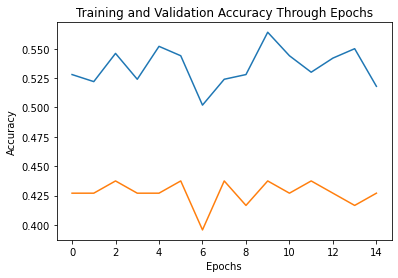

In [18]:
plt.plot(training_accuracy_list)
plt.plot(validation_accuracy_list)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Through Epochs")

In [19]:
# Use the test function you defined above to test your network after training
test_accuracy = check_accuracy(test_convnet, test_dataloader)
print(f'Test accuracy after training: {test_accuracy * 100 :.2f}%')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Test accuracy after training: 53.33%
